## Dropout

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # https://stackoverflow.com/questions/35911252/disable-tensorflow-debugging-information
tf.logging.set_verbosity(tf.logging.ERROR)

Instructions for updating:
non-resource variables are not supported in the long term


#### 1. Prepare the data

In [2]:
from tensorflow.keras import datasets, utils

(train_data, train_label), (test_data, test_label) = datasets.mnist.load_data()

train_data = train_data.reshape(60000, 784) / 255.0
test_data = test_data.reshape(10000, 784) / 255.0

train_label = utils.to_categorical(train_label) # 0~9 -> one-hot vector
test_label = utils.to_categorical(test_label) # 0~9 -> one-hot vector

11501568/11490434 [==============================] - 0s 0us/step


#### 2. Build the model

In [3]:
X = tf.placeholder(tf.float32, [None, 784])
Y = tf.placeholder(tf.float32, [None, 10])

In [4]:
# 살려줄 node의 비율
keep_prob = tf.placeholder(tf.float32) 

In [5]:
W1 = tf.Variable(tf.random_normal([784, 256], stddev=0.01))
L1 = tf.nn.relu(tf.matmul(X, W1))
L1 = tf.nn.dropout(L1, keep_prob) # Dropout을 적용할 layer & 살릴 비율

In [6]:
W2 = tf.Variable(tf.random_normal([256, 256], stddev=0.01))
L2 = tf.nn.relu(tf.matmul(L1, W2))
L2 = tf.nn.dropout(L2, keep_prob) # Dropout을 적용할 layer & 살릴 비율

- 살릴 비율을 숫자로 안하는 이유는 training 단계 때 바꿔주기 때문

In [7]:
W3 = tf.Variable(tf.random_normal([256, 10], stddev=0.01))
model = tf.matmul(L2, W3)

#### 3. Set the criterion

In [8]:
cost = tf.losses.softmax_cross_entropy(Y, model) 
optimizer = tf.train.AdamOptimizer(0.001).minimize(cost)

#### 4. Train the model

In [9]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

In [10]:
batch_size = 100
total_batch = int(len(train_data) / batch_size)
print(total_batch)

600


In [11]:
for epoch in range(15):
    
    
    total_cost = 0
    batch_idx = 0
    
    for i in range(total_batch):
        
        batch_x = train_data[ batch_idx : batch_idx + batch_size ]
        batch_y = train_label[ batch_idx : batch_idx + batch_size ]
        
        sess.run(optimizer, feed_dict={X: batch_x, 
                                       Y: batch_y, 
                                       keep_prob: 0.8}) # node 중 80%만 유지하고 20%를 train 시마다 off
        
        batch_cost = sess.run(cost, feed_dict={X: batch_x, 
                                               Y: batch_y, 
                                               keep_prob: 0.8})
        total_cost = total_cost + batch_cost
        
        batch_idx += batch_size
    
    
    training_cost = total_cost / total_batch
    
    
    print('Epoch: {}'.format(epoch + 1), 
          '|| Avg. Training cost = {:.3f}'.format(training_cost))

print('Learning process is completed!')

Epoch: 1 || Avg. Training cost = 0.416
Epoch: 2 || Avg. Training cost = 0.161
Epoch: 3 || Avg. Training cost = 0.108
Epoch: 4 || Avg. Training cost = 0.081
Epoch: 5 || Avg. Training cost = 0.065
Epoch: 6 || Avg. Training cost = 0.052
Epoch: 7 || Avg. Training cost = 0.046
Epoch: 8 || Avg. Training cost = 0.038
Epoch: 9 || Avg. Training cost = 0.035
Epoch: 10 || Avg. Training cost = 0.030
Epoch: 11 || Avg. Training cost = 0.029
Epoch: 12 || Avg. Training cost = 0.028
Epoch: 13 || Avg. Training cost = 0.024
Epoch: 14 || Avg. Training cost = 0.023
Epoch: 15 || Avg. Training cost = 0.020
Learning process is completed!


#### 5. Test the model

In [12]:
is_correct = tf.equal(tf.argmax(model, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32))

In [13]:
print('정확도:', sess.run(accuracy,
                        feed_dict={X: test_data,
                                   Y: test_label,
                                   keep_prob: 1})) # 정확도를 측정하는 Test 단계에서는 전체 Node를 살려줘야 합니다.

정확도: 0.9813


#### + Appendix. Save the predicted values

In [14]:
# 모델의 예측값을 labels에 저장
labels = sess.run(tf.argmax(model, 1),
                  feed_dict={X: test_data,
                             Y: test_label,
                             keep_prob: 1}) 
print(labels)

[7 2 1 ... 4 5 6]


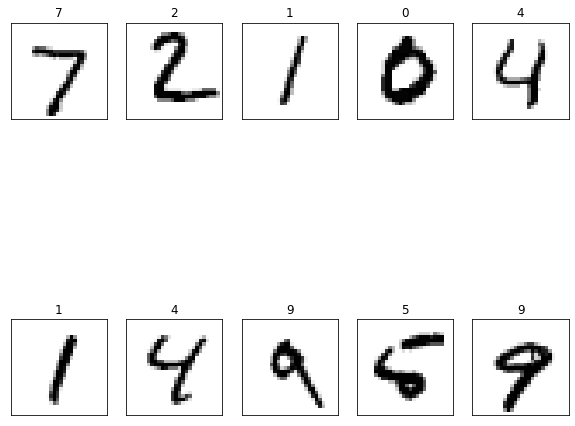

In [15]:
fig = plt.figure(figsize=(10, 10))

for i in range(10):
    subplot = fig.add_subplot(2, 5, i + 1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.set_title('%d' % labels[i])
    subplot.imshow(test_data[i].reshape((28, 28)),
                   cmap=plt.cm.gray_r)

plt.show() # 상단의 번호가 예측된 숫자, 아래의 이미지가 실제 데이터(이미지 내 숫자)